##### - TODO moze jakas analiza tych akcji (Power text)??

In [2]:
import pandas as pd
from scripts.helper import *
import matplotlib.pyplot as plt
import seaborn.objects as so

In [3]:
ptaki_df = pd.read_json('data/master.json')
names = ptaki_df["Common name"]
ptaki_df = ptaki_df.drop(["id","rulings","Expansion","additionalRulings", "Scientific name", "Forest", "Flocking",
    "Grassland","Wetland", "Note","Anatomist",
    "Cartographer",
    "Historian",
    "Photographer",
    "Backyard Birder",
    "Bird Bander",
    "Bird Counter",
    "Bird Feeder",
    "Diet Specialist",
    "Enclosure Builder",
    "Falconer",
    "Fishery Manager",
    "Food Web Expert",
    "Forester",
    "Large Bird Specialist",
    "Nest Box Builder",
    "Omnivore Expert",
    "Passerine Specialist",
    "Platform Builder",
    "Prairie Manager",
    "Rodentologist",
    "Viticulturalist",
    "Wetland Scientist",
    "Wildlife Gardener",
    "Caprimulgiform Specialist",
    "Small Clutch Specialist",
    "Endangered Species Protector",
    "Beak Pointing Left",
    "Beak Pointing Right"], axis =1)

In [4]:
ptaki_df["PowerCategory"] = ptaki_df["PowerCategory"].apply(lambda x: x if x not in {"Hunting and fishing", "Hunting and Fishing"} else "Hunting/Fishing")
ptaki_df["PowerCategory"] = ptaki_df["PowerCategory"].apply(lambda x: x if x != "Tucking" else "Flocking")
ptaki_df.groupby(["PowerCategory"]).size()

PowerCategory
Caching Food            12
Card-drawing            35
Egg-laying              35
Flocking                51
Food from Birdfeeder    12
Food from Supply        19
Food-related            48
Hunting/Fishing         40
Other                   74
dtype: int64

In [5]:
ptaki_df["Power text"] = ptaki_df["Power text"].fillna("None")
ptaki_df["lay"] = ptaki_df["Power text"].apply(lambda x: 0 if x.find(" lay")== -1 else 1)
ptaki_df["player"] = ptaki_df["Power text"].apply(lambda x: 0 if x.find("player")== -1 else 1)

ptaki_df = ptaki_df.drop("Power text",axis =1)
#keywords: lay, player 


/home/julia/miniconda3/envs/sklearn_env/lib/python3.12/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


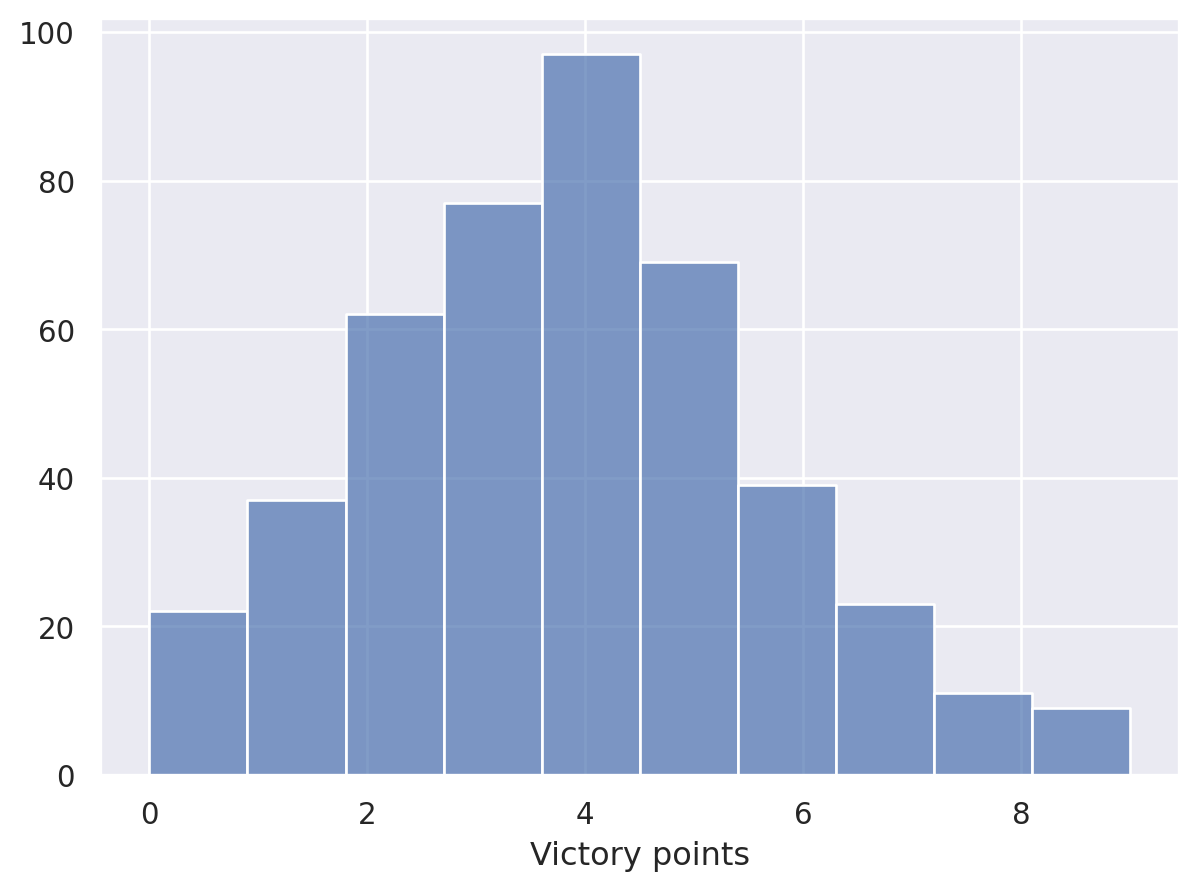

In [6]:
ptaki_df["Victory points"] = ptaki_df["Victory points"].apply(lambda x: float(x))
p = so.Plot(ptaki_df, "Victory points")
p.add(so.Bars(), so.Hist(bins=10))

In [7]:
ptaki_df["Special Wingspan"] = ptaki_df["Wingspan"].apply(lambda x: 0 if x != "*" else 1)
ptaki_df["Wingspan"] = ptaki_df["Wingspan"].apply(lambda x: float(x) if x != "*" else 0) # na pewno dac 0 jak specjalne?
#p = so.Plot(ptaki_df, "Wingspan")
#p.add(so.Bars(), so.Hist(bins =20))

In [8]:
ptaki_df = ptaki_df.fillna(0)
cols = ['Predator','Bonus card','/ (food cost)', '* (food cost)']

for col in cols:
    ptaki_df[col]= ptaki_df[col].apply(lambda x: 1 if x != 0 else x)
    
for c in ["Color", "PowerCategory"]:
    ptaki_df[c]= ptaki_df[c].apply(lambda x: "None" if x == 0 else x)

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
    [('norm_length', MinMaxScaler(), ['Wingspan']),
    ('one_hot_nest', OneHotEncoder(), ['Color','Nest type',  'PowerCategory'])],
    remainder='drop', verbose_feature_names_out=False)

column_trans.fit(ptaki_df)
column_trans.get_feature_names_out()

X_trans = column_trans.transform(ptaki_df.drop("Victory points", axis =1))

In [10]:
from sklearn.model_selection import train_test_split
X = X_trans
y = ptaki_df["Victory points"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [1]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE().fit_resample(X, y)


fig, axs = plt.subplots(1,3, layout= 'constrained')
axs[0].hist(y)
axs[1].hist(y_train)
axs[2].hist(y_test)
axs[0].set_xlabel("Victory points")
plt.show()

NameError: name 'X' is not defined

## SVM


#### classification

In [10]:
X = X_trans
y = ptaki_df["Victory points"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)

In [11]:
from sklearn import svm
classs = svm.SVC()
classs.fit(X_train, y_train)

svm_pred = classs.predict(X_test)

In [12]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, svm_pred)

Accuracy: 0.1791044776119403


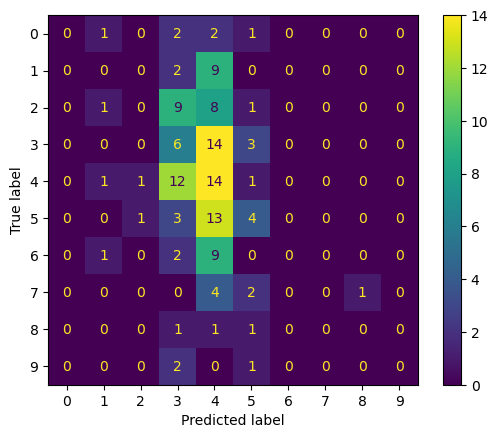

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf)
disp.plot()
from sklearn.metrics import accuracy_score
print("Accuracy: " + str(accuracy_score(y_test, svm_pred)))

Accuracy: 0.1791044776119403


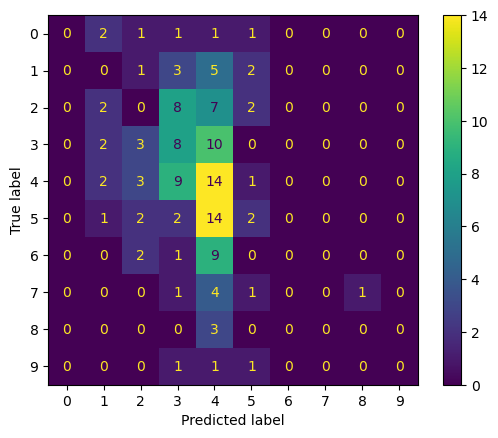

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1.0)
logreg.fit(X_train, y_train)

lgr_pred = logreg.predict(X_test)

confl = confusion_matrix(y_test, lgr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confl)
disp.plot()

from sklearn.metrics import accuracy_score
print("Accuracy: " + str(accuracy_score(y_test, lgr_pred)))

Accuracy: 0.1417910447761194


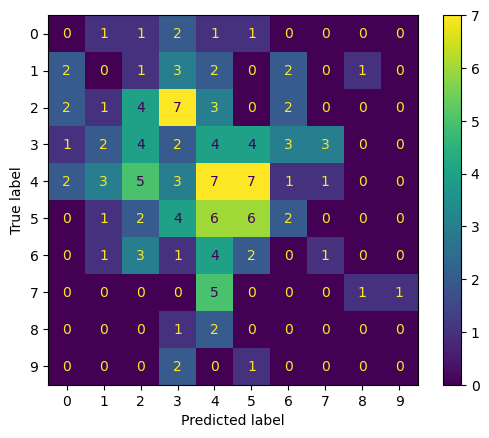

In [15]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

tree_pred = tree.predict(X_test)

conft = confusion_matrix(y_test, tree_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conft)
disp.plot()

from sklearn.metrics import accuracy_score
print("Accuracy: " + str(accuracy_score(y_test, tree_pred)))

Accuracy: 0.15671641791044777


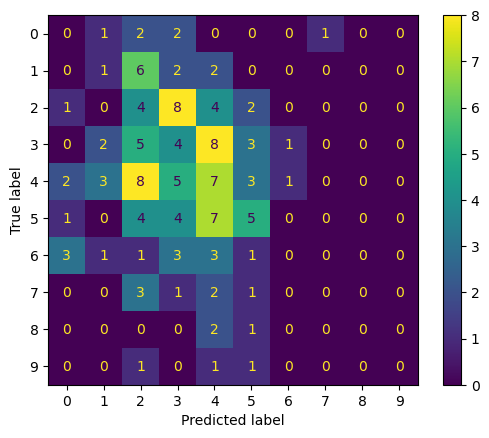

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn =  KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

confk = confusion_matrix(y_test, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confk)
disp.plot()

from sklearn.metrics import accuracy_score
print("Accuracy: " + str(accuracy_score(y_test, knn_pred)))

/home/julia/miniconda3/envs/sklearn_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.17164179104477612


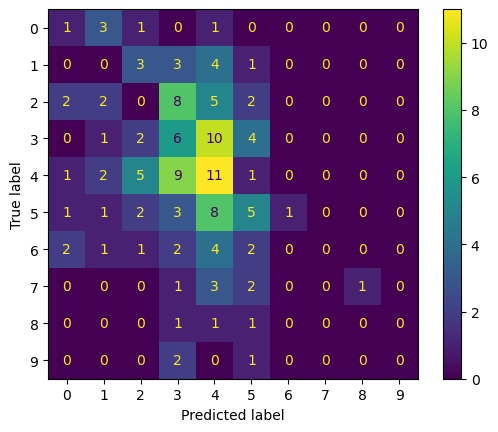

In [30]:
from sklearn.neural_network import MLPClassifier

nn =  MLPClassifier()
nn.fit(X_train, y_train)

nn_pred = nn.predict(X_test)

confn = confusion_matrix(y_test, nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confn)
disp.plot()

from sklearn.metrics import accuracy_score
print("Accuracy: " + str(accuracy_score(y_test, nn_pred)))

In [25]:
power_df = pd.read_json('data/master.json')
power_df = power_df[["Power text", "Victory points", "Total food cost"]]

TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.